Load libraries

In [1]:
from data_loader import load_cifar10
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, f1_score

In [2]:
data = load_cifar10("cifar-10-batches-py")
X_train, y_train = data["x_train"], data["y_train"]
X_test, y_test   = data["x_test"], data["y_test"]
label_names = data["label_names"]

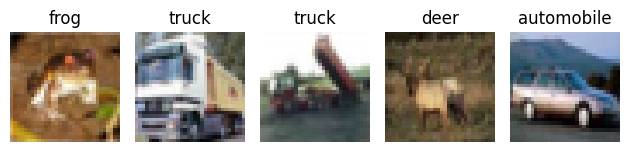

In [3]:
for i in range(5):
    img = X_train[i]
    label_idx = y_train[i]
    label_name = label_names[label_idx]

    ax = plt.subplot(1, 5, i + 1)
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

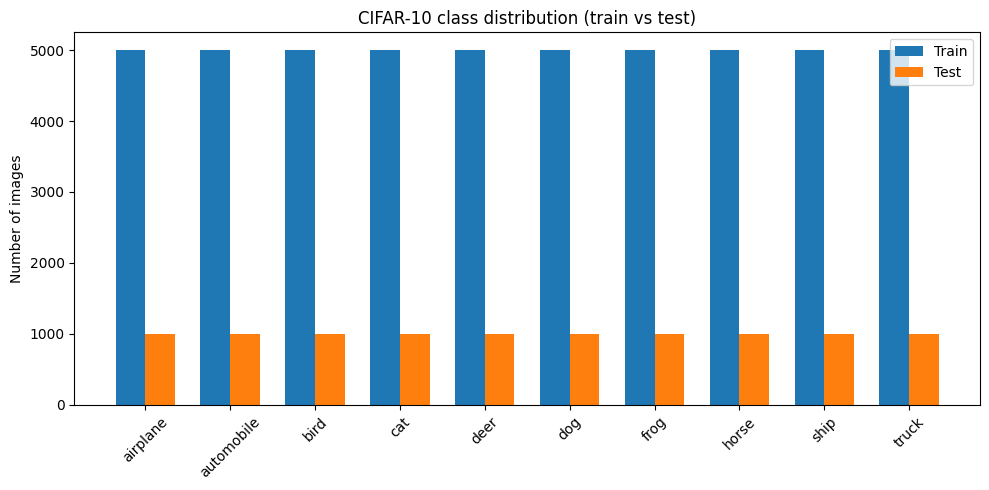

In [4]:
# Count instances per class for train and test
train_counts = np.bincount(y_train, minlength=len(label_names))
test_counts  = np.bincount(y_test,  minlength=len(label_names))

x = np.arange(len(label_names))  # class indices
width = 0.35                     # bar width

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train_counts, width, label="Train")
plt.bar(x + width/2, test_counts,  width, label="Test")

plt.xticks(x, label_names, rotation=45)
plt.ylabel("Number of images")
plt.title("CIFAR-10 class distribution (train vs test)")
plt.legend()
plt.tight_layout()
plt.show()


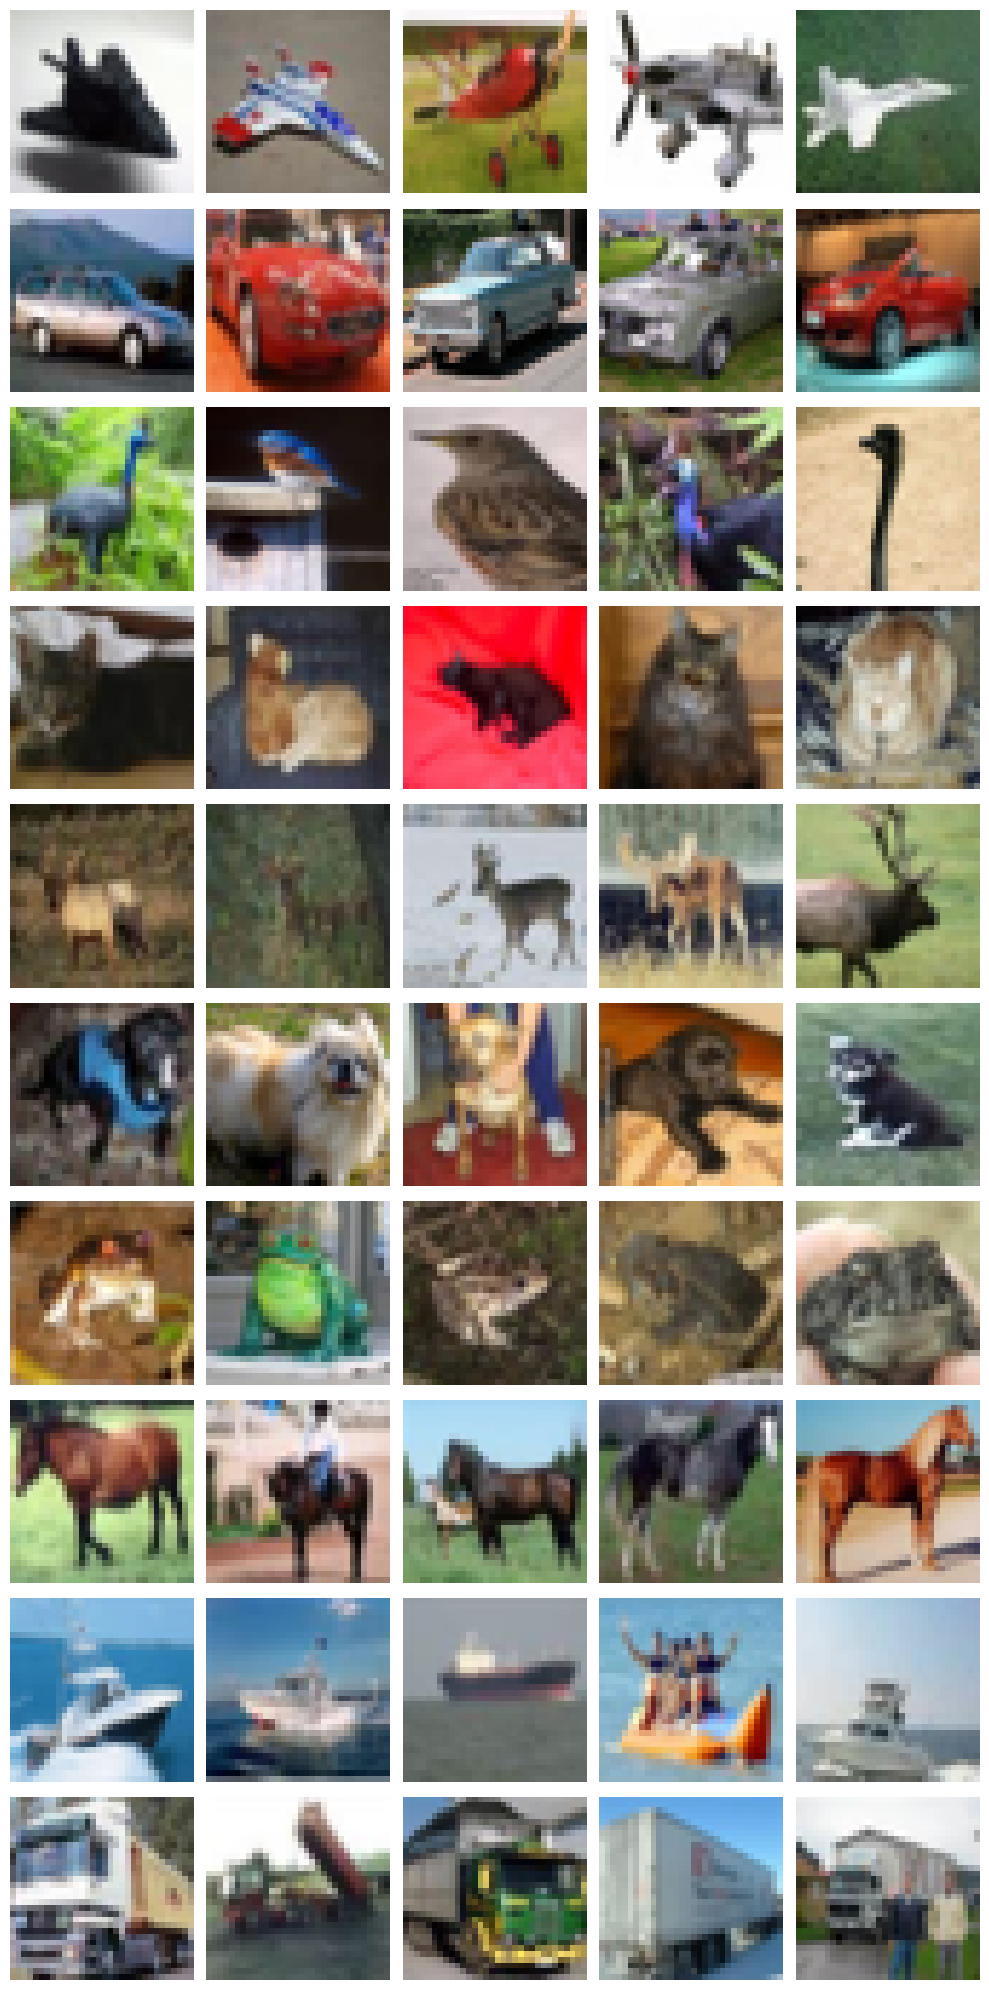

In [5]:
num_classes = len(label_names)
num_examples_per_class = 5

plt.figure(figsize=(num_examples_per_class * 2, num_classes * 2))

for class_idx in range(num_classes):
    # indices of images belonging to this class
    idxs = np.where(y_train == class_idx)[0]
    # pick first N (or random if you prefer)
    chosen_idxs = idxs[:num_examples_per_class]

    for j, img_idx in enumerate(chosen_idxs):
        plt_idx = class_idx * num_examples_per_class + j + 1
        ax = plt.subplot(num_classes, num_examples_per_class, plt_idx)
        ax.imshow(X_train[img_idx])
        if j == 0:
            ax.set_ylabel(label_names[class_idx], rotation=0, labelpad=40,
                          va="center", ha="right", fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.show()


Flatten + scale images <br>
CIFAR-10: (N, 32, 32, 3) -> (N, 3072)

In [6]:
X_train_flat = X_train.reshape(len(X_train), -1) / 255.0
X_test_flat  = X_test.reshape(len(X_test), -1) / 255.0

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
X_train_flat.shape

(50000, 3072)

In [9]:

# Υποθετουμε οτι:
# X_train_flat, X_test_flat ειναι ηδη φλαταρισμενα και scaled
# y_train, y_test ειναι np.arrays με labels 0..9
# label_names = ["airplane", "automobile", ..., "truck"]

num_classes = len(label_names)

# ποσα θελουμε ανα κλαση
n_train_per_class = 1000
n_test_per_class  = 200

rng = np.random.default_rng(0)  # για αναπαραγωγιμοτητα

# ----------------------------
# Stratified sampling για TRAIN
# ----------------------------
train_indices = []

for c in range(num_classes):
    class_idxs = np.where(y_train == c)[0]
    # ασφαλεια: να μην ζητησουμε περισσοτερα απο οσα υπαρχουν
    if len(class_idxs) < n_train_per_class:
        raise ValueError(
            f"Not enough train samples for class {c}: "
            f"have {len(class_idxs)}, requested {n_train_per_class}"
        )
    chosen = rng.choice(class_idxs, size=n_train_per_class, replace=False)
    train_indices.append(chosen)

train_indices = np.concatenate(train_indices)
rng.shuffle(train_indices)  # ανακατεμα για να μην ειναι ολα της ιδιας κλασης μαζι

X_train_sub = X_train_flat[train_indices]
y_train_sub = y_train[train_indices]

# ----------------------------
# Stratified sampling για TEST
# ----------------------------
test_indices = []

for c in range(num_classes):
    class_idxs = np.where(y_test == c)[0]
    if len(class_idxs) < n_test_per_class:
        raise ValueError(
            f"Not enough test samples for class {c}: "
            f"have {len(class_idxs)}, requested {n_test_per_class}"
        )
    chosen = rng.choice(class_idxs, size=n_test_per_class, replace=False)
    test_indices.append(chosen)

test_indices = np.concatenate(test_indices)
rng.shuffle(test_indices)

X_test_sub = X_test_flat[test_indices]
y_test_sub = y_test[test_indices]

print("Train shape:", X_train_sub.shape, "Test shape:", X_test_sub.shape)


Train shape: (10000, 3072) Test shape: (2000, 3072)


Define SVM configurations <br>
Mix of linear / non-linear kernels and params

In [15]:
model_configs = [
    {
        "name": "LinearSVC_C1",
        "cls": LinearSVC,
        "params": {"C": 1.0, "max_iter": 5000},
    },
    {
        "name": "SVC_poly_deg3_C1",
        "cls": SVC,
        "params": {"kernel": "poly", "degree": 3, "C": 1.0, "gamma": "scale"},
    },
    {
        "name": "SVC_linear_C1",
        "cls": SVC,
        "params": {"kernel": "linear", "C": 1.0},
    },
    {
        "name": "SVC_rbf_C1_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 1.0, "gamma": 1e-3},
    },
    {
        "name": "SVC_rbf_C10_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 10.0, "gamma": 1e-3},
    },
    {
        "name": "SVC_rbf_C100_gamma1e-3",
        "cls": SVC,
        "params": {"kernel": "rbf", "C": 100.0, "gamma": 1e-3},
    }
]

Train all models, time them, compute metrics

In [ ]:
results = []  # list of dicts, one per model

for cfg in model_configs:
    print(f"\nTraining {cfg['name']}...")
    model = cfg["cls"](**cfg["params"])

    start = time.perf_counter()
    model.fit(X_train_sub, y_train_sub)
    train_time = time.perf_counter() - start

    y_pred = model.predict(X_test_sub)
    acc = accuracy_score(y_test_sub, y_pred)
    macro_f1 = f1_score(y_test_sub, y_pred, average="macro")

    results.append({
        "name": cfg["name"],
        "model": model,              # trained model object
        "train_time": train_time,
        "test_accuracy": acc,
        "test_macro_f1": macro_f1,
    })
    print(f"Done in {train_time:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(results[-1])


Training LinearSVC_C1...
Done in 17.65 sec - Test Acc: 0.3385, Macro F1: 0.3191
{'name': 'LinearSVC_C1', 'model': LinearSVC(max_iter=5000), 'train_time': 17.651716299998952, 'test_accuracy': 0.3385, 'test_macro_f1': 0.3191178319042876}

Training SVC_poly_deg3_C1...


Train with whole dataset

In [ ]:
results = []  # list of dicts, one per model

for cfg in model_configs:
    print(f"\nTraining {cfg['name']}...")
    model = cfg["cls"](**cfg["params"])

    start = time.perf_counter()
    model.fit(X_train_flat, y_train)
    train_time = time.perf_counter() - start

    y_pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "name": cfg["name"],
        "model": model,              # trained model object
        "train_time": train_time,
        "test_accuracy": acc,
        "test_macro_f1": macro_f1,
    })
    print(f"Done in {train_time:.2f} sec - Test Acc: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(results[-1])


Training LinearSVC_C1...
Done in 115.95 sec - Test Acc: 0.3854, Macro F1: 0.3707
{'name': 'LinearSVC_C1', 'model': LinearSVC(max_iter=5000), 'train_time': 115.9480593999615, 'test_accuracy': 0.3854, 'test_macro_f1': 0.37072591855909}

Training SVC_linear_C1...
Done in 5029.83 sec - Test Acc: 0.3163, Macro F1: 0.2946
{'name': 'SVC_linear_C1', 'model': SVC(kernel='linear'), 'train_time': 5029.830503199948, 'test_accuracy': 0.3163, 'test_macro_f1': 0.2946035323818386}

Training SVC_rbf_C1_gamma1e-3...
Done in 6686.59 sec - Test Acc: 0.2531, Macro F1: 0.2036
{'name': 'SVC_rbf_C1_gamma1e-3', 'model': SVC(gamma=0.001), 'train_time': 6686.588238299941, 'test_accuracy': 0.2531, 'test_macro_f1': 0.20364255392893119}

Training SVC_rbf_C10_gamma1e-3...


KeyboardInterrupt: 